In [1]:
import datetime as dt
import numpy as np

from birkeland import Model
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator, MultipleLocator

# Define some plotting functions
These are some plotting functions just to help the plots below look better.

In [2]:
def add_cax(fig, ax, pad=0.05, width=0.01, position="right"):
    """Add a colourbar axis to a figure."""
    if isinstance(ax, np.ndarray):
        if len(ax.shape) == 1:
            ax_bbox = ax[-1].get_position()
            cax_bbox = ax_bbox

            if position == "right":
                cax_bbox.y0 = ax[0].get_position().y0
            else:
                cax_bbox.x0 = ax[0].get_position().x0
        else:
            ax_bbox = ax[-1, -1].get_position()
            cax_bbox = ax_bbox

            if position == "right":
                cax_bbox.y1 = ax[0, -1].get_position().y1
            else:
                cax_bbox.x0 = ax[-1, 0].get_position().x0
    else:
        ax_bbox = ax.get_position()
        cax_bbox = ax_bbox

    if position == "right":
        cax_bbox.x0 = ax_bbox.x1 + pad
        cax_bbox.x1 = cax_bbox.x0 + width
    elif position == "below":
        cax_bbox.y1 = ax_bbox.y0 - pad
        cax_bbox.y0 = cax_bbox.y1 - width
    else:
        raise ValueError('Position must be "right" or "below".')

    cax = fig.add_axes(cax_bbox)

    return cax

def configure_polar_plot(ax, rmax, colat_grid_spacing=10, theta_range=None, mlt=True):
    """Configures a polar plot with midnight at the bottom and sensible labelling."""

    # Configure colatitude.
    ax.set_rmin(0.0)
    ax.set_rmax(rmax)
    ax.yaxis.set_major_locator(MultipleLocator(colat_grid_spacing))

    ax.set_theta_zero_location("S")

    if theta_range is not None:
        ax.set_thetamin(theta_range[0])
        ax.set_thetamax(theta_range[1])

    if mlt:
        ax.xaxis.set_major_formatter(format_mlt())
        ax.xaxis.set_major_locator(MultipleLocator(np.pi / 2))

    ax.grid(True)
    
def format_mlt():
    """Return MLT in hours rather than a number of degrees when drawing axis labels."""

    # noinspection PyUnusedLocal
    def formatter_function(y, pos):
        hours = y * (12 / np.pi)
        if hours == 24:
            return ""
        else:
            if hours < 0:
                hours += 24
            return f"{hours:.0f}"

    return FuncFormatter(formatter_function)

# Reproduce the plots from Milan (2013)
The below code instantiates the two examples from Milan (2013) and attempts to reproduce the plots from Milan (2013).

In [3]:
example1 = Model(50, 0, 0.4)
example2 = Model(30, 70, 0.7)

## Reproduce Figure 2a–d

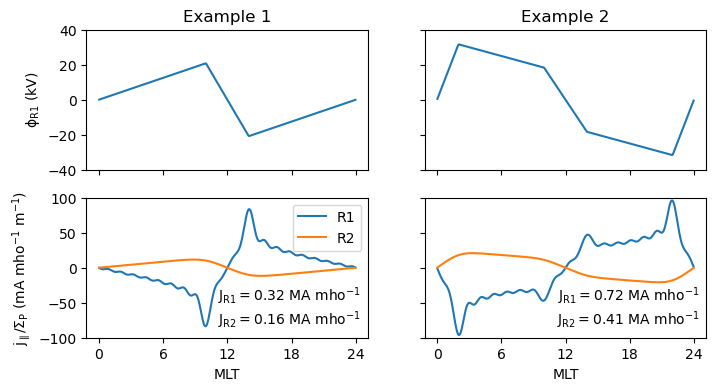

In [4]:
per_string = r"$^{-1}$"

fig, ax = plt.subplots(2, 2, figsize=(8, 4), sharex="all", sharey="row")

for cnt, example in enumerate((example1, example2)):
    ax[0, cnt].plot(example.mlt, example.phi_r1() / 1e3)
    
    ax[1, cnt].plot(example.mlt, example.j_r1_intensity() * 1e3,
                    label="R1")
    ax[1, cnt].plot(example.mlt, example.j_r2_intensity() * 1e3,
                    label="R2")
    
    r1_string = (r"$\mathregular{J_{R1}=}$"
                 + f"{example.j_r1_integrated() / 1e6:.2f} MA mho" + per_string)
    r2_string = (r"$\mathregular{J_{R2}=}$" 
                 + f"{example.j_r2_integrated() / 1e6:.2f} MA mho" + per_string)                        
    
    ax[1, cnt].annotate(r1_string + "\n" + r2_string,
                        (1, 0), xycoords="axes fraction",
                        xytext=(-5, 5), textcoords="offset points",
                        ha="right", va="bottom", fontsize=10)
    
ylabel = ("$\mathregular{j_\parallel/\Sigma_P}$"
          + " (mA mho" + per_string + " m" + per_string + ")")

ax[0, 0].xaxis.set_major_locator(MultipleLocator(6))
ax[1, 0].legend(loc="upper right")

ax[0, 0].set(title="Example 1", ylabel=r"$\mathregular{\phi_{R1}}$" + " (kV)", ylim=(-40, 40))
ax[0, 1].set(title="Example 2")
ax[1, 0].set(xlabel="MLT", ylabel=ylabel, ylim=(-100, 100))
ax[1, 1].set(xlabel="MLT")

plt.show()

## Reproduce the contours in Figure 2e-j

The contours are at intervals of 10 kV from 5 kV upward; the 6 kV interval stated in the caption to Figure 2 is a typographical error.

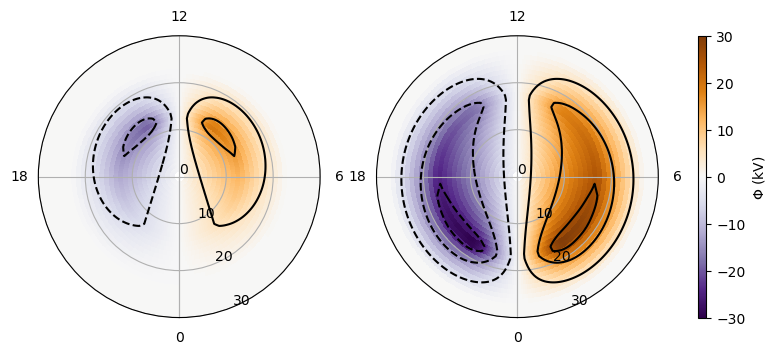

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), subplot_kw={"polar": True})
mesh = np.empty_like(ax, dtype=object)

phi_contours = np.concatenate((np.arange(-25, 0, 10), np.arange(5, 30, 10))) * 1e3

for cnt, example in enumerate([example1, example2]):
    mesh[cnt] = ax[cnt].pcolormesh(example.theta, example.colat,
                                   example.phi / 1e3, cmap="PuOr_r",
                                   vmin=-30, vmax=30, shading="nearest")
    ax[cnt].contour(example.theta, example.colat,
                    example.phi, levels=phi_contours, colors="black")
    configure_polar_plot(ax[cnt], 30)

cax = add_cax(fig, ax)
cbar = plt.colorbar(mesh[0], cax=cax)
cbar.set_label("$\mathregular{\Phi}$ (kV)")

## Reproduce the maps in Figures 2e-h

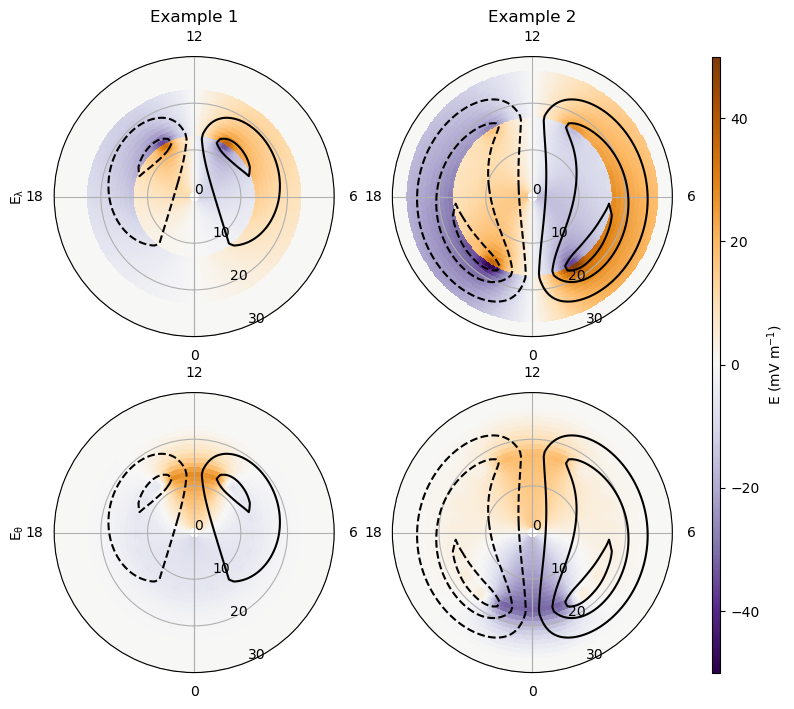

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={"polar": True})
mesh = np.empty_like(ax, dtype=object)

for cnt, example in enumerate([example1, example2]):
    mesh[0, cnt] = ax[0, cnt].pcolormesh(example.theta, example.colat,
                                         example.e_labda * 1e3, cmap="PuOr_r",
                                         vmin=-50, vmax=50, shading="nearest")
    mesh[1, cnt] = ax[1, cnt].pcolormesh(example.theta, example.colat,
                                         example.e_theta * 1e3, cmap="PuOr_r",
                                         vmin=-50, vmax=50, shading="nearest")
    ax[0, cnt].set_title(f"Example {cnt + 1}")
    
    for a in ax[:, cnt]:
        a.contour(example.theta, example.colat, example.phi,
                  levels=phi_contours, colors="black")
        configure_polar_plot(a, 30)
        
ax[0, 0].set_ylabel(r"$\mathregular{E_\lambda}$", labelpad=20)
ax[1, 0].set_ylabel(r"$\mathregular{E_\theta}$", labelpad=20)

cax = add_cax(fig, ax)
cbar = plt.colorbar(mesh[0, 1], cax=cax)
cbar.ax.yaxis.set_major_locator(MaxNLocator(6))
cbar.set_label("E (mV m" + per_string + ")")

## Reproduce Figure 2i–j

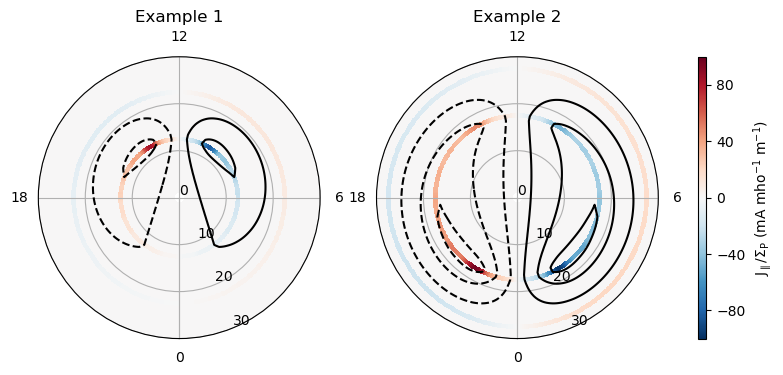

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), subplot_kw={"polar": True})
mesh = np.empty_like(ax, dtype=object)

for cnt, example in enumerate([example1, example2]):
    mesh[cnt] = ax[cnt].pcolormesh(example.theta, example.colat,
                                   example.j * 1e3, cmap="RdBu_r",
                                   vmin=-100, vmax=100, shading="nearest")
    
    ax[cnt].contour(example.theta, example.colat, example.phi,
                    levels=phi_contours, colors="black")
    ax[cnt].set_title(f"Example {cnt + 1}")
    configure_polar_plot(ax[cnt], 30)

cax = add_cax(fig, ax)
cbar = plt.colorbar(mesh[1], cax=cax)
cbar.ax.yaxis.set_major_locator(MaxNLocator(6))
cbar.set_label(r"$\mathregular{J_\parallel/\Sigma_P}$ (mA mho" 
               + per_string + " m" + per_string + ")")

## Plot the ionospheric flow vector

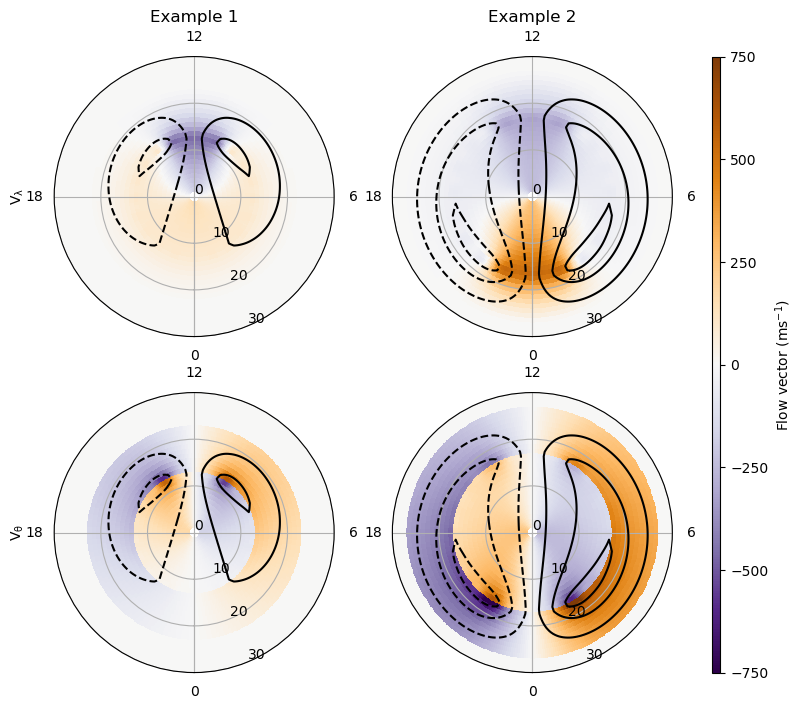

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={"polar": True})
mesh = np.empty_like(ax, dtype=object)
clim = 10 * np.round(np.max(np.abs((example.v_labda, example.v_theta))) / 10)

for cnt, example in enumerate([example1, example2]):
    mesh[0, cnt] = ax[0, cnt].pcolormesh(example.theta, example.colat,
                                         example.v_labda, cmap="PuOr_r",
                                         vmin=-750, vmax=750, shading="nearest")
    mesh[1, cnt] = ax[1, cnt].pcolormesh(example.theta, example.colat,
                                         example.v_theta, cmap="PuOr_r",
                                         vmin=-750, vmax=750, shading="nearest")
    ax[0, cnt].set_title(f"Example {cnt + 1}")
    
    for a in ax[:, cnt]:
        a.contour(example.theta, example.colat, example.phi,
                  levels=phi_contours, colors="black")
        configure_polar_plot(a, 30)

ax[0, 0].set_ylabel(r"$\mathregular{V_\lambda}$", labelpad=20)
ax[1, 0].set_ylabel(r"$\mathregular{V_\theta}$", labelpad=20)

cax = add_cax(fig, ax)
cbar = plt.colorbar(mesh[0, 1], cax=cax)
cbar.ax.yaxis.set_major_locator(MaxNLocator(6))
cbar.set_label("Flow vector (ms" + per_string + ")")